# Train Hate Speech Recognition Models

With the data cleaned and processed, this notebook implements model training on the data sets. The code in this notebook assumes that cleaned data is in the filepath `"data/combined_deduped.csv"`. 

## Imports

In [35]:
import pandas as pd
import numpy as np
import spacy
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import wandb
from tensorflow import keras
from wandb.keras import WandbCallback
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [ ]:
nlp = spacy.load("en_core_web_lg")

## Helper Functions

We'll start by fitting basic models with default parameters. As machine learning models and neural networks have many hyperparameters that can be tweaked, these will serve as a baseline: combinations of hyperparameter settings that improve the model from this baseline should be investigated, while those that degrade model performance should be seen as less promising.

As modeling is an iterative process, we start by establishing some functions to automate the repetitive aspects of establishing baselines.

In [36]:
def reset_data_with_val():
    """
    Loads data, returns training and validation data"""
    tweets = pd.read_csv("data/combined_deduped.csv")
    train, test = train_test_split(tweets, test_size = .2, random_state=42)
    train, val = train_test_split(train, test_size = .15, random_state = 42)
    x_train, y_train, x_val, y_val = train["tweet"], train["inappropriate"], val["tweet"], val["inappropriate"]
    
    return x_train, y_train, x_val, y_val

In [37]:
def baseline_model(vect, clf, x_train, y_train, x_val, y_val, scaling=False):
    """Takes a text vectorizer, a classification model, and 
    data and outputs that model's score on the data.
    
    Sub-arguments can be passed to the arguments in the function: 
    for example, passing `vect = CountVectorizer(stop_words='english')`.
    However, as this function doesn't return a fitted model, just model
    scores, it is primarily intended to quickly test many basic 
    model archetypes.

    Arguments:
        vect {vectorizer} -- e.g. CountVectorizer(), TfidfVectorizer()
        clf {classifier} -- eg RandomForest(), MultinomialNB()
        x_train {array} -- features and values of the training set
        y_train {1d array} -- target values for the training set
        x_val {array} -- features and values of the validation set
        y_val {1d array} -- target values for the validation set
    
    Keyword Arguments:
        scaling {bool} -- scale data if required by model (default: {False})
    
    Returns:
        accuracy, precision, recall, f1, roc_auc -- metrics of model performance
    """
    x_train = vect.fit_transform(x_train)
    x_val = vect.transform(x_val)
    
    if scaling == True:
        scaler = StandardScaler(with_mean=False)
        x_train = scaler.fit_transform(x_train)
        x_val = scaler.fit_transform(x_val)
        
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_val)
    
    accuracy = clf.score(x_val, y_val)
    precision, recall, f1, other = precision_recall_fscore_support(y_val, 
                                                                   y_pred, 
                                                                   average='binary')
    roc_auc = roc_auc_score(y_val, y_pred)

    return accuracy, precision, recall, f1, roc_auc

In [38]:
def report_to_wandb(accuracy, precision, recall, f1, roc_auc):
    """Reports a dictionary summarizing model performance
    to the "Weights and Biases" app associated with this project.
    
    Arguments:
        accuracy {float} -- [description]
        precision {float} -- [description]
        recall {float} -- [description]
        f1 {float} -- [description]
        roc_auc {float} -- [description]
    """
    wandb.log({'accuracy':accuracy, 'recall':recall, 
               'f1':f1, 'precision':precision, 
               'roc_auc_score':roc_auc})

In [39]:
x_train, y_train, x_val, y_val = reset_data_with_val()

In [40]:
def implement_training(vect, clf, 
    x_train=x_train, y_train=y_train, 
    x_val=x_val, y_val=y_val):
    """This function initializes a weights and biases run, then calls the 
    helper functions in order to perform a full cycle of model training.

    Note that attempting to define this function before x_train, y_train, 
    x_val, and y_val are assigned local variables will generate an error, as 
    they're called as the default arguments. These have been set as default
    arguments for convenience when fitting multiple models. 
    
    Arguments:
        vect {Vectorizer} -- sklearn-compatible text vectorizer
        clf {Classifier} -- sklearn-compatible classification model
    
    Keyword Arguments:
        x_train {array} -- training features/values (default: {x_train})
        y_train {1d array} -- training target values (default: {y_train})
        x_val {array} -- validation features/values (default: {x_val})
        y_val {1d array} -- validation target values (default: {y_val})
    """
    wandb.init(project="allay-ds-23")
    accuracy, precision, recall, f1, roc_auc = baseline_model(vect, clf, 
                                        x_train, y_train, 
                                        x_val, y_val)
    report_to_wandb(accuracy, precision, recall, f1, roc_auc)

    return("Accuracy:", accuracy, "Precision:", precision,
        "Recall:", recall, "F1:", f1, "ROC_AUC:", roc_auc)

# Baseline ML Models

## Majority Classifier

In [9]:
y_val.value_counts(normalize=True)

False    0.582441
True     0.417559
Name: inappropriate, dtype: float64

In [12]:
y_pred = y_val * 0
print(classification_report(y_val, y_pred, digits=4))

              precision    recall  f1-score   support

       False     0.5824    1.0000    0.7361     10223
        True     0.0000    0.0000    0.0000      7329

    accuracy                         0.5824     17552
   macro avg     0.2912    0.5000    0.3681     17552
weighted avg     0.3392    0.5824    0.4288     17552



C:\Users\ajenk\.virtualenvs\allay-ds-cRyEcJS9\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic Regression

In [13]:
vect = CountVectorizer()
clf = LogisticRegression()

In [14]:
implement_training(vect, clf)

C:\Users\ajenk\.virtualenvs\allay-ds-cRyEcJS9\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


('Accuracy:',
 0.8650296262534184,
 'Precision:',
 0.8802514566084023,
 'Recall:',
 0.7833265111202073,
 'F1:',
 0.8289654176593747,
 'ROC_AUC:',
 0.8534650749868863)

In [38]:
vect = TfidfVectorizer()

In [32]:
baseline_model(vect, clf, x_train, y_train, x_val, y_val)

(0.863320419325433,
 0.8849156777014366,
 0.7732296356938191,
 0.8253112939634457,
 0.8505686474468312)

In [39]:
implement_training(vect, clf)

('Accuracy:',
 0.863320419325433,
 '/nPrecision:',
 0.8849156777014366,
 '/nRecall:',
 0.7732296356938191,
 '/nF1:',
 0.8253112939634457,
 '/nROC_AUC:',
 0.8505686474468312)

## Naive Bayes

In [41]:
vect = CountVectorizer()
clf = MultinomialNB()

In [42]:
implement_training(vect, clf)

('Accuracy:',
 0.8469690063810392,
 'Precision:',
 0.8710244526130734,
 'Recall:',
 0.743621230727248,
 'F1:',
 0.8022964816723098,
 'ROC_AUC:',
 0.8323407924153701)

In [43]:
vect = TfidfVectorizer()
implement_training(vect, clf)

('Accuracy:',
 0.8229831358249772,
 'Precision:',
 0.9211891460494812,
 'Recall:',
 0.6299631600491199,
 'F1:',
 0.7482375820435944,
 'ROC_AUC:',
 0.7956623977884257)

## SVM

In [8]:
vect = CountVectorizer()
clf = LinearSVC()

In [9]:
implement_training(vect, clf)

C:\Users\ajenk\.virtualenvs\allay-ds-cRyEcJS9\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


('Accuracy:',
 0.8507292616226071,
 'Precision:',
 0.8453865336658354,
 'Recall:',
 0.7863282848956201,
 'F1:',
 0.8147886328290682,
 'ROC_AUC:',
 0.8416137169367077)

In [10]:
vect = TfidfVectorizer()
clf = LinearSVC()

In [11]:
implement_training(vect, clf)

('Accuracy:',
 0.8605287146763901,
 'Precision:',
 0.8562253685593344,
 'Recall:',
 0.8003820439350525,
 'F1:',
 0.8273624823695346,
 'ROC_AUC:',
 0.8520153396824827)

## Random Forest

In [12]:
vect = CountVectorizer()
clf = RandomForestClassifier()

In [13]:
implement_training(vect, clf)

('Accuracy:',
 0.8521536007292616,
 'Precision:',
 0.9043389135633755,
 'Recall:',
 0.7223359257743212,
 'F1:',
 0.8031555791549723,
 'ROC_AUC:',
 0.8337787425017551)

In [14]:
vect = TfidfVectorizer()

In [15]:
implement_training(vect, clf)

('Accuracy:',
 0.8327825888787602,
 'Precision:',
 0.8206363105662581,
 'Recall:',
 0.7672260881429935,
 'F1:',
 0.7930329313870671,
 'ROC_AUC:',
 0.8235034871899551)

## Gradient-Boosted Trees

In [19]:
vect = CountVectorizer()
clf = XGBClassifier()

In [20]:
implement_training(vect, clf)

('Accuracy:',
 0.8648587055606198,
 'Precision:',
 0.9335315725030611,
 'Recall:',
 0.7282030290626279,
 'F1:',
 0.8181818181818182,
 'ROC_AUC:',
 0.8455159721269317)

In [21]:
vect = TfidfVectorizer()

In [22]:
implement_training(vect, clf)

('Accuracy:',
 0.85859161349134,
 'Precision:',
 0.9106931028639214,
 'Recall:',
 0.7332514667758221,
 'F1:',
 0.8123960695389266,
 'ROC_AUC:',
 0.8408505206323598)

# Neural Network Baselines

The "baseline" implementation of a neural network is more debatable. Our choice was to set up a simple multilayer perceptron with enough neurons and layers to be functional and little customization beyond that. 

The text vectorization methods used for baseline modeling generate a sparse matrix of word appearances. This needs to be converted into a dense array for our Keras model to 

In [21]:
vect = CountVectorizer(stop_words = 'english', max_features=3000)
x_train_vect = vect.fit_transform(x_train)
x_val_vect = vect.transform(x_val)

In [22]:
scaler = StandardScaler(with_mean = False)
x_train_vect_scale = scaler.fit_transform(x_train_vect)
x_val_vect_scale = scaler.transform(x_val_vect)

In [23]:
x_train_vect_scale = x_train_vect_scale.toarray()
x_val_vect_scale = x_val_vect_scale.toarray()

In [24]:
model = Sequential([
    Dense(128, input_dim=3000, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
              ])

In [25]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
wandb.init(project="allay-ds-23")

results = model.fit(x_train_vect_scale,
                    y_train,
                    epochs=5,
                   batch_size=20)

Train on 99459 samples
Epoch 1/5
99459/99459 [==============================] - 37s 376us/sample - loss: 0.6787 - accuracy: 0.8567
Epoch 2/5
99459/99459 [==============================] - 24s 239us/sample - loss: 0.2212 - accuracy: 0.9178
Epoch 3/5
99459/99459 [==============================] - 23s 231us/sample - loss: 0.1629 - accuracy: 0.9403
Epoch 4/5
99459/99459 [==============================] - 23s 227us/sample - loss: 0.1284 - accuracy: 0.9523
Epoch 5/5
99459/99459 [==============================] - 22s 216us/sample - loss: 0.1105 - accuracy: 0.9586


In [42]:
score = model.evaluate(x_val_vect_scale, y_val)
y_pred = model.predict(x_val_vect_scale, batch_size=64, verbose=1)
y_pred = np.round(y_pred)

17552/17552 [==============================] - 3s 188us/sample


In [43]:
print(classification_report(y_val, y_pred, digits=4))

              precision    recall  f1-score   support

       False     0.8485    0.8924    0.8699     10223
        True     0.8382    0.7777    0.8069      7329

    accuracy                         0.8445     17552
   macro avg     0.8434    0.8351    0.8384     17552
weighted avg     0.8442    0.8445    0.8436     17552



In [44]:
accuracy, precision, recall, f1 = .8445, .8382, .7777, .8069

wandb.log({'accuracy':accuracy, 'recall':recall, 
               'f1':f1, 'precision':precision})

In [45]:
vect = TfidfVectorizer(stop_words = 'english', max_features=3000)
x_train_vect = vect.fit_transform(x_train)
x_val_vect = vect.transform(x_val)

In [46]:
x_train_vect = x_train_vect.toarray()
x_val_vect = x_val_vect.toarray()

In [47]:
model = Sequential([
    Dense(128, input_dim=3000, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
              ])

In [48]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
wandb.init(project="allay-ds-23")
results = model.fit(x_train_vect,
                    y_train,
                    epochs=5,
                   batch_size=20)

Train on 99459 samples
Epoch 1/5
99459/99459 [==============================] - 25s 253us/sample - loss: 0.3500 - accuracy: 0.8495
Epoch 2/5
99459/99459 [==============================] - 31s 307us/sample - loss: 0.3024 - accuracy: 0.8731
Epoch 3/5
99459/99459 [==============================] - 20s 206us/sample - loss: 0.2700 - accuracy: 0.8885
Epoch 4/5
99459/99459 [==============================] - 20s 204us/sample - loss: 0.2257 - accuracy: 0.9090
Epoch 5/5
99459/99459 [==============================] - 20s 203us/sample - loss: 0.1735 - accuracy: 0.9319


In [51]:
y_pred = model.predict(x_val_vect, batch_size=64, verbose=1)
y_pred = np.round(y_pred)
print(classification_report(y_val, y_pred, digits=4))

17552/17552 [==============================] - 1s 54us/sample
              precision    recall  f1-score   support

       False     0.8541    0.9035    0.8781     10223
        True     0.8535    0.7847    0.8177      7329

    accuracy                         0.8539     17552
   macro avg     0.8538    0.8441    0.8479     17552
weighted avg     0.8538    0.8539    0.8528     17552



In [53]:
accuracy, precision, recall, f1 = .8539, .8535, .7847, .8177

wandb.log({'accuracy':accuracy, 'recall':recall, 
               'f1':f1, 'precision':precision})

# ML Models: Hyperparameter Tuning and Performance

## Logistic Regression

## Naive Bayes

## SVM

## Random Forest

## Gradient-Boosted Trees

## NNs: Hyperparameter Tuning and Performance

# Performance Graph

Our models are tracked to the website Weights and Biases (wandb.com). We'll be using that to systematically log model performance and improvement. For our baseline models, I've grabbed the data off Weights and Biases, dropped the models that either didn't finish or aren't part of the baseline, and graphed both by run number and by accuracy rank.

These models are then compared to a baseline of .59 (majority-classifier model performance) and a target goal of .9 (what we think is a plausible score to shoot for with model tuning and improvement.

In [154]:
results_table = pd.read_csv("wandb//wandb_export_2020-04-23T12_51_21.251-04_00.csv")

In [155]:
results_table.head()

,Name,_wandb,recall,accuracy,precision,f1,roc_auc_score
0,playful-glade-20,NaN,0.798200,0.854300,0.844300,0.820600,NaN
1,eager-snowflake-19,NaN,0.777700,0.844500,0.838200,0.806900,NaN
2,blooming-cosmos-18,NaN,0.783327,0.865030,0.880251,0.828965,0.853465
3,revived-snowball-17,NaN,0.781962,0.866112,0.884004,0.829858,0.854201
4,fancy-dragon-16,NaN,0.733251,0.858592,0.910693,0.812396,0.840851


In [156]:
results_table = results_table[results_table.accuracy > .5]
results_table = results_table.drop([2, 3, 16])
results_table = results_table.drop(["_wandb", "roc_auc_score"], axis=1)
results_table = results_table.reset_index().drop(["index"], axis=1)
results_table = results_table.reset_index()
results_table["run_number"] = 11 - results_table["index"]
results_table = results_table.drop(["index"], axis = 1)

results_table

,Name,recall,accuracy,precision,f1,run_number
0,playful-glade-20,0.798200,0.854300,0.844300,0.820600,11
1,eager-snowflake-19,0.777700,0.844500,0.838200,0.806900,10
2,fancy-dragon-16,0.733251,0.858592,0.910693,0.812396,9
3,fast-yogurt-15,0.728203,0.864859,0.933532,0.818182,8
4,stellar-forest-14,0.767226,0.832783,0.820636,0.793033,7
5,bright-frost-13,0.722336,0.852154,0.904339,0.803156,6
6,earthy-cherry-12,0.800382,0.860529,0.856225,0.827362,5
7,valiant-snow-11,0.786328,0.850729,0.845387,0.814789,4
8,radiant-gorge-9,0.629963,0.822983,0.921189,0.748238,3
9,morning-sun-8,0.743621,0.846969,0.871024,0.802296,2


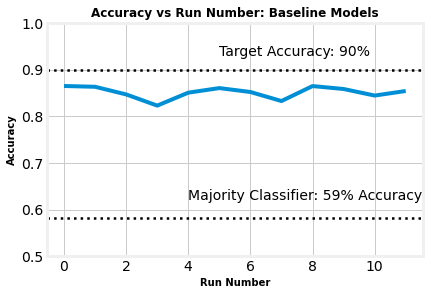

In [157]:
fig, ax = plt.subplots()
plt.style.use("fivethirtyeight")
fig.patch.set(facecolor="white")
ax.set(facecolor="white")

ax.plot(results_table["run_number"], results_table["accuracy"])
ax.axhline(y = .582, linestyle='dotted', linewidth=2.5, color='black')
ax.axhline(y = .9, linestyle='dotted', linewidth=2.5 ,color='black')
ax.set_yticks([.5, .6, .7, .8, .9, 1])

ax.set_xlabel("Run Number", fontweight = "bold", size = 10)
ax.set_ylabel("Accuracy", fontweight = "bold", size = 10)
ax.set_title("Accuracy vs Run Number: Baseline Models", fontweight = "bold", size = 12)
ax.annotate('Target Accuracy: 90%', xy=(5, .93))
ax.annotate('Majority Classifier: 59% Accuracy', xy=(4, .62))

plt.savefig("AccuracyVsRun")
plt.show()

In [158]:
results_table = results_table.sort_values(by = ["accuracy"])
results_table= results_table.reset_index().reset_index()
results_table["model_rank"] = results_table["level_0"]
results_table = results_table.drop(["level_0", "index"], axis=1)

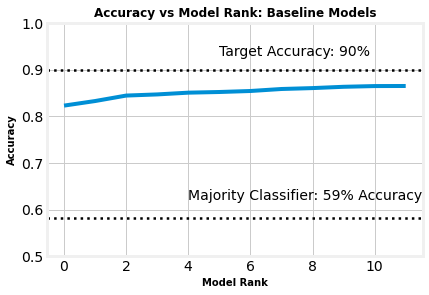

In [159]:
fig, ax = plt.subplots()
plt.style.use("fivethirtyeight")
fig.patch.set(facecolor="white")
ax.set(facecolor="white")

ax.plot(results_table["model_rank"], results_table["accuracy"])
ax.axhline(y = .582, linestyle='dotted', linewidth=2.5, color='black')
ax.axhline(y = .9, linestyle='dotted', linewidth=2.5 ,color='black')
ax.set_yticks([.5, .6, .7, .8, .9, 1])

ax.set_xlabel("Model Rank", fontweight = "bold", size = 10)
ax.set_ylabel("Accuracy", fontweight = "bold", size = 10)
ax.set_title("Accuracy vs Model Rank: Baseline Models", fontweight = "bold", size = 12)
ax.annotate('Target Accuracy: 90%', xy=(5, .93))
ax.annotate('Majority Classifier: 59% Accuracy', xy=(4, .62))

plt.savefig("AccuracyVsRank.png")
plt.show()